<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/fMRIexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fMRI finger tapping task example

A finger tapping task is done with fMRI where the subject does alternating 24-second-long blocks of fixation and finger tapping. The blood oxygenation-dependent signal (BOLD signal) is sampled at 4 Hz (i.e., MRI TR = 250 ms). This yields 96 samples of fixation images and 96 samples of finger tapping images.

Note that although fMRI data are volumetric (i.e., 3 spatial dimensions), only a single slice is provided here by taking advantage of *a priori* knowledge about where activation is likely to be observed.

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## Structual MRI for overlay

fMRI data (i.e., BOLD data) are T2-weighted images. A structural image (T1-weighted imaged) is provided for overlay purposes in the file ```motor.png```.

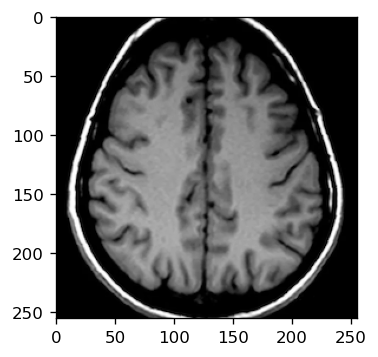

In [2]:
import imageio
I = imageio.imread('motor.png', as_gray=True)
I = np.float64(I)/255.
pl.imshow(I, cmap='gray', vmin=0, vmax=1)

## BOLD data

fMRI data for 96 samples of each of two conditions is available in ```bold_data.mat```. Let's start by examining the contents of thhis file.

In [3]:
from scipy import io
dat = io.loadmat('bold_data.mat', squeeze_me=True)

In [4]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'fix', 'fs', 'tap'])

In [5]:
dat['fs']

4

In [6]:
dat['fix'].shape

(96, 256, 256)

In [7]:
dat['tap'].shape

(96, 256, 256)

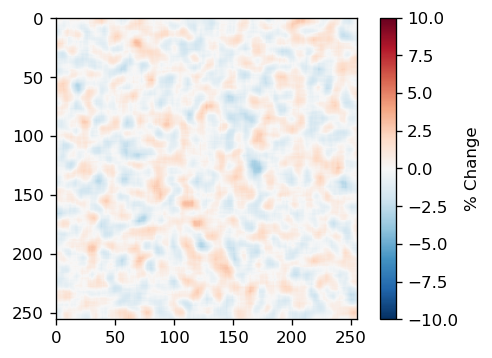

In [8]:
F = dat['fix'].mean(axis=0) * 100
pl.imshow(F, cmap='RdBu_r', vmin=-10, vmax=10)
pl.colorbar(label='% Change')

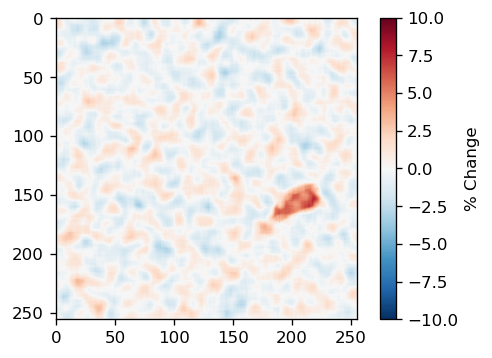

In [9]:
T = dat['tap'].mean(axis=0) * 100
pl.imshow(T, cmap='RdBu_r', vmin=-10, vmax=10)
pl.colorbar(label='% Change')

## Permutation Statistics

As usual, under the null hypothesis $\mathcal{H}_0$, there is no difference between tehh BOLD signal anywhhere in the brain slice between the ```fix``` and ```tap``` conditions. So to generate examples of data that we'd get when $\mathcal{H}_0$ is true, you can swap the two conditions.

In [10]:
basket = np.concatenate((dat['fix'], dat['tap']), axis=0)

In [11]:
basket.shape

(192, 256, 256)

In [12]:
Nperms = 100
maxvals = np.zeros(Nperms)  # To store the peak we get under the null
nsamps = dat['fix'].shape[0]
for k in range(Nperms):
    order = np.random.permutation(2 * nsamps)
    Fperm = basket[order[:nsamps], :, :].mean(axis=0)
    Tperm = basket[order[nsamps:], :, :].mean(axis=0)
    maxvals[k] = (Tperm - Fperm).max()

(array([ 1.,  1.,  3.,  3.,  4.,  9., 11., 14., 12.,  8.,  5.,  8., 11.,
         2.,  5.,  0.,  2.,  0.,  0.,  1.]),
 array([0.03995566, 0.04107895, 0.04220223, 0.04332552, 0.0444488 ,
        0.04557209, 0.04669537, 0.04781866, 0.04894194, 0.05006523,
        0.05118851, 0.0523118 , 0.05343508, 0.05455837, 0.05568165,
        0.05680494, 0.05792822, 0.05905151, 0.06017479, 0.06129808,
        0.06242136]),
 <BarContainer object of 20 artists>)

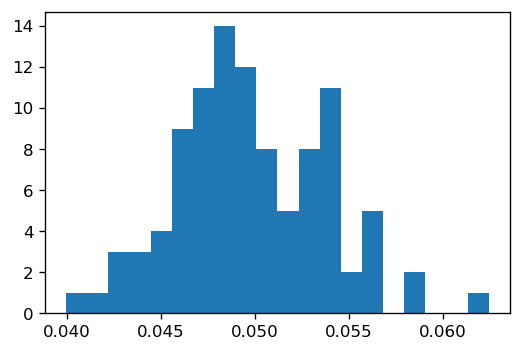

In [13]:
pl.hist(maxvals, bins=20)

## Get threshold from $\mathcal{H}_0$ examples

In [14]:
maxvals.sort()
alpha = 0.05
threshold = maxvals[np.int32((1 - alpha) * Nperms)]
print(f'The threshold for alpha = {alpha} is {threshold * 100} %')

The threshold for alpha = 0.05 is 5.622200021755268 %


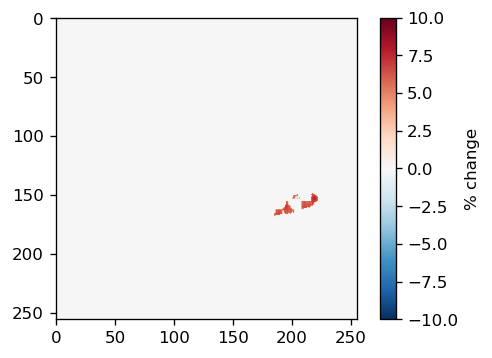

In [15]:
cutoff = threshold * 100
D = T - F
overlay = np.zeros(D.shape)
overlay[D > cutoff] = D[D > cutoff].copy()

pl.imshow(overlay, cmap='RdBu_r', vmin=-10, vmax=10)
pl.colorbar(label='% change')

## Overlay structural image and thresholded functional data

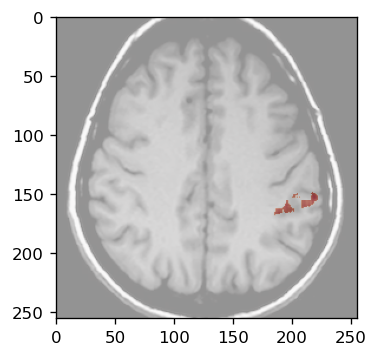

In [16]:
pl.imshow(I, cmap='gray', vmin=0, vmax=1)
pl.imshow(overlay, cmap='RdBu_r', vmin=-10, vmax=10, alpha=0.6)